In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load datasets

In [2]:
pressures_no_leakage3h_mean = pd.read_csv("../data/aggregation/pressures_aggregated_scenario1.csv")
flows_no_leakage3h_mean = pd.read_csv("../data/aggregation/flows_aggregated_scenario1.csv")

pressures_no_leakage3h_mean["Timestamp"] = pd.to_datetime(pressures_no_leakage3h_mean["Timestamp"])
flows_no_leakage3h_mean["Timestamp"] = pd.to_datetime(flows_no_leakage3h_mean["Timestamp"])

pressures_no_leakage3h_mean.set_index("Timestamp", inplace=True)
flows_no_leakage3h_mean.set_index("Timestamp", inplace=True)

# Train SARIMA model on scenario without leakage

First of all, we have to check if our time series (*pressures* and *flows*) are stationary:

## Identify seasonnality 

### Pressures

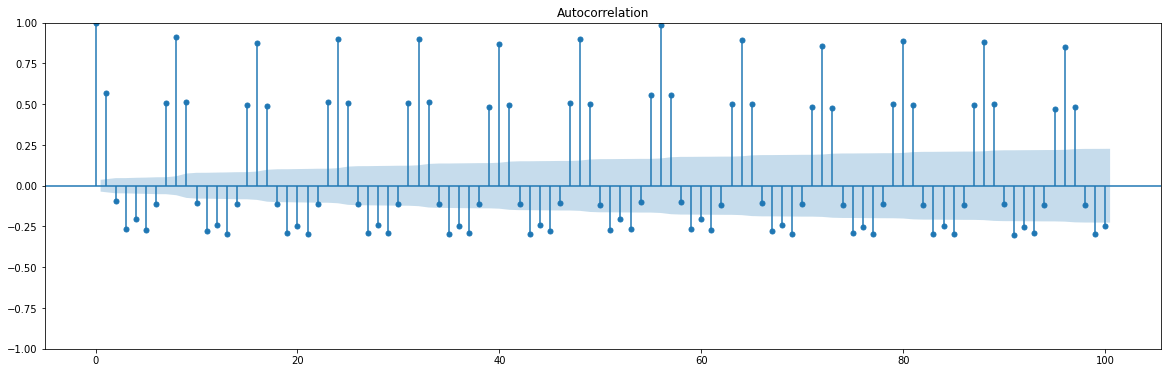

In [84]:
N, M = 20, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(pressures_no_leakage3h_mean["node_21_mean"], lags = 100, ax=ax)
plt.show()

We can easily confirm the hypothesis that our time serie on pressures contains a seasonality of 8 (1 day). We can see that our series seems to contains a cycle of 56 (i.e 7 days).

### Flows

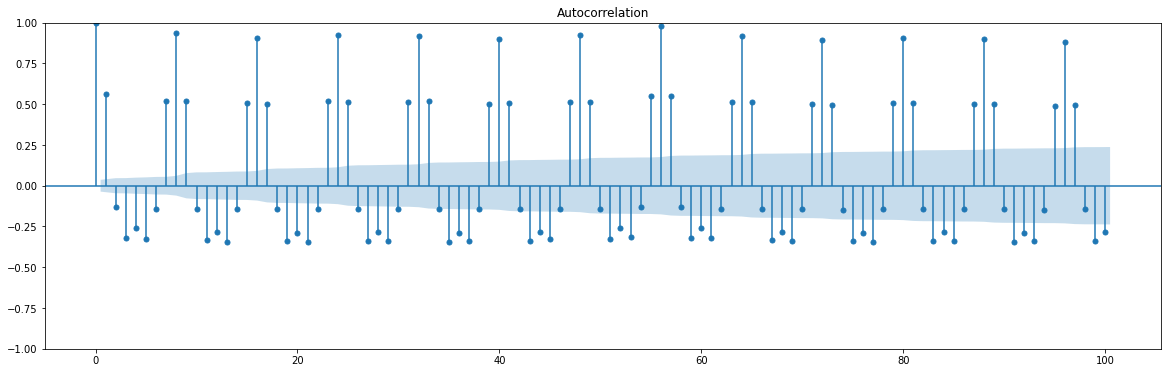

In [85]:
N, M = 20, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(flows_no_leakage3h_mean["link_21_mean"], lags = 100, ax=ax)
plt.show()

We have the same observations for flows 

We differenciate then our time series to absorb the seasonality. We have $s = 8$ and we try to estimate parameter $D$ of SARIMA model

## Identify D

In [88]:
pressures_diff = pressures_no_leakage3h_mean["node_21_mean"].diff(periods=8).dropna()
flows_diff = flows_no_leakage3h_mean["link_21_mean"].diff(periods=8).dropna()

### Pressures

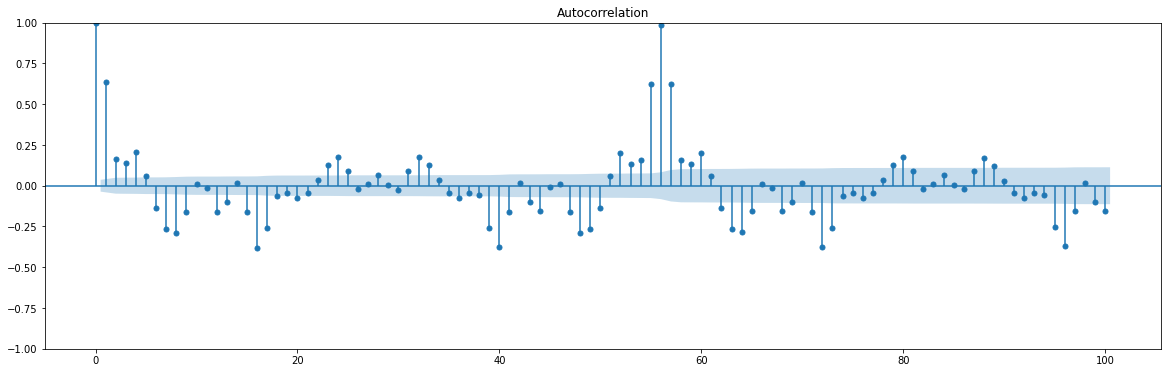

In [93]:
N, M = 20, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(pressures_diff, lags = 100, ax=ax)
plt.show()

### Flows

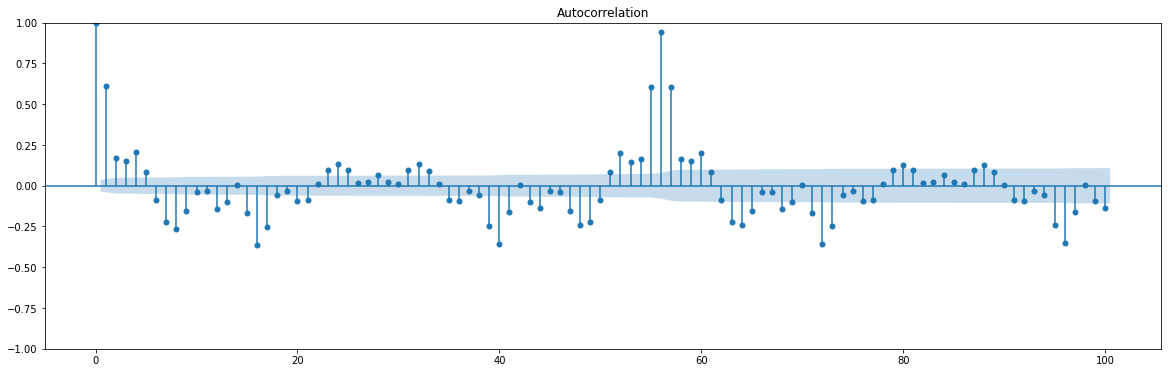

In [94]:
N, M = 20, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(flows_diff, lags = 100, ax=ax)
plt.show()

Our acf seems to be simple autocorrelograms, we can then say $D = 1$

## Check stationarity

We apply the ADF test to our 2 time series to check if they are stationnary or not and to determine $d$

In [95]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print("the serie is stationary")
    else:
        print("the serie is NOT stationary")

In [96]:
print("Pressure node 21 differenciate")
check_stationarity(pressures_diff)

Pressure node 21 differenciate
1. ADF :  -12.949001592217696
2. P-Value :  3.4076131135327646e-24
3. Num Of Lags :  28
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2883
5. Critical Values :
	 1% :  -3.432620250421088
	 5% :  -2.8625430431586545
	 10% :  -2.567303948779845
the serie is stationary


In [97]:
print("Flow link 21 differenciate")
check_stationarity(flows_diff)

Flow link 21 differenciate
1. ADF :  -12.909983024778054
2. P-Value :  4.076265688543343e-24
3. Num Of Lags :  28
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2883
5. Critical Values :
	 1% :  -3.432620250421088
	 5% :  -2.8625430431586545
	 10% :  -2.567303948779845
the serie is stationary


According to the ADF test, the 2 time series at the differenciation 0 are stationnary

So we have 
$
d = 0 
$
for the 2 models

## Plot PACF to determine the $p$ and the $P$ parameter

### Pressures

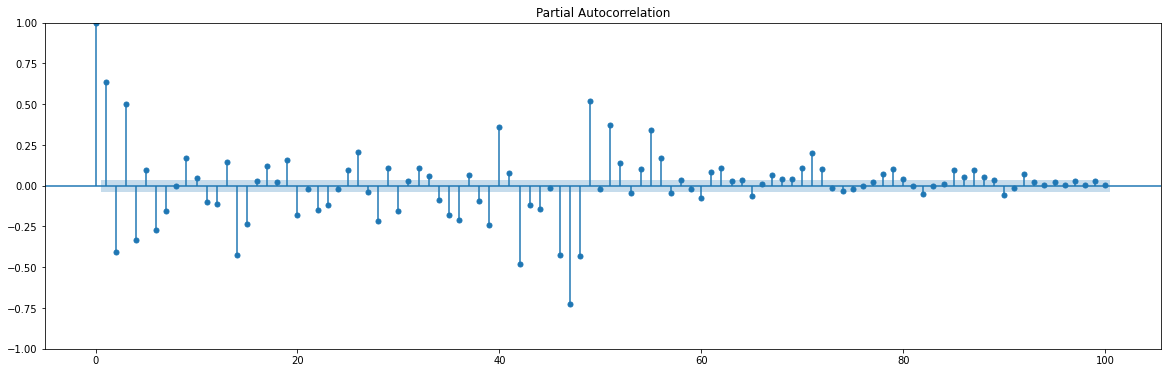

In [98]:
N, M = 20, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_pacf(pressures_diff, lags = 100, method="ywm", ax=ax)
plt.show()

The most significant pic for the $AR$ order seems to be the first pic, so $p = 1$. For the seasonal order, the most significant pic seems to be at the 48th pic, so the seasonal order is $P=6$ 

### Flows

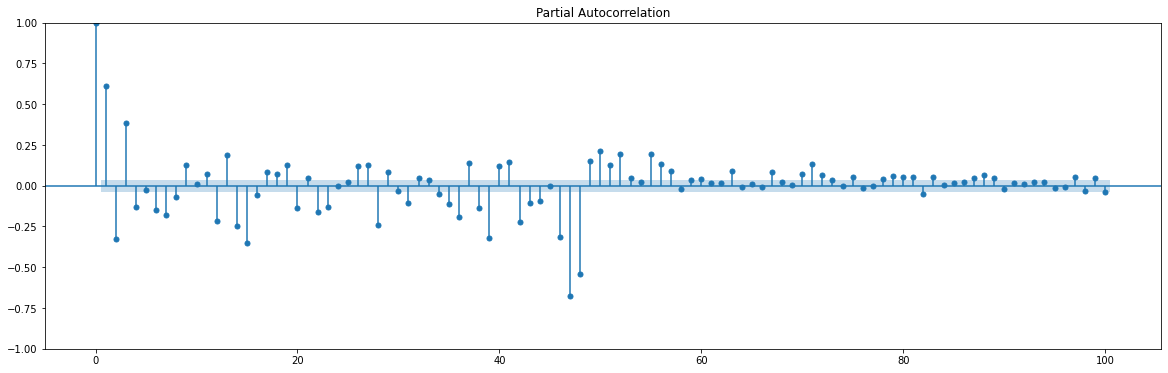

In [99]:
N, M = 20, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_pacf(flows_diff, lags = 100, method="ywm", ax=ax)
plt.show()

The observations are the same for the flows, so $p=1$ and $P=6$

## Plot ACF to determine the $q$ and the $Q$ parameter

### Pressures

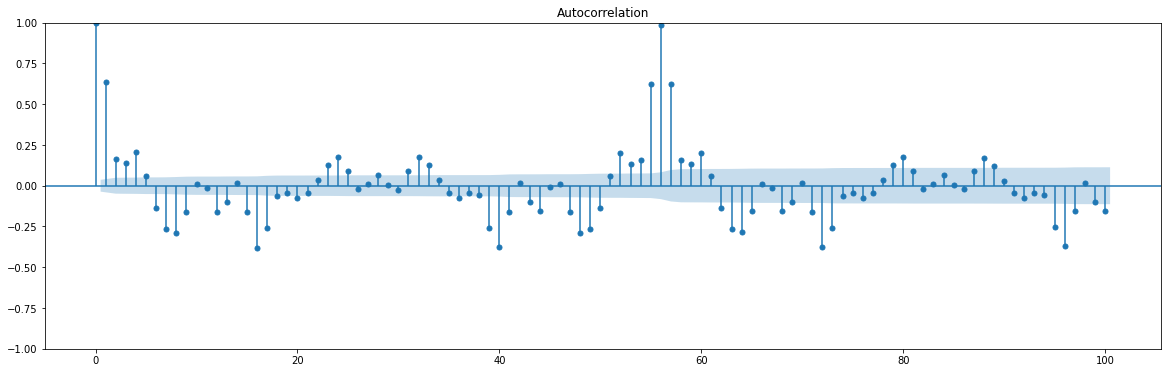

In [100]:
N, M = 20, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(pressures_diff, lags=100, ax=ax)
plt.show()

For the pressures, $q$ seems to be equal to 1 : $q=1$ and $Q$ seems to be equal to 7 : $Q=7$

### Flows

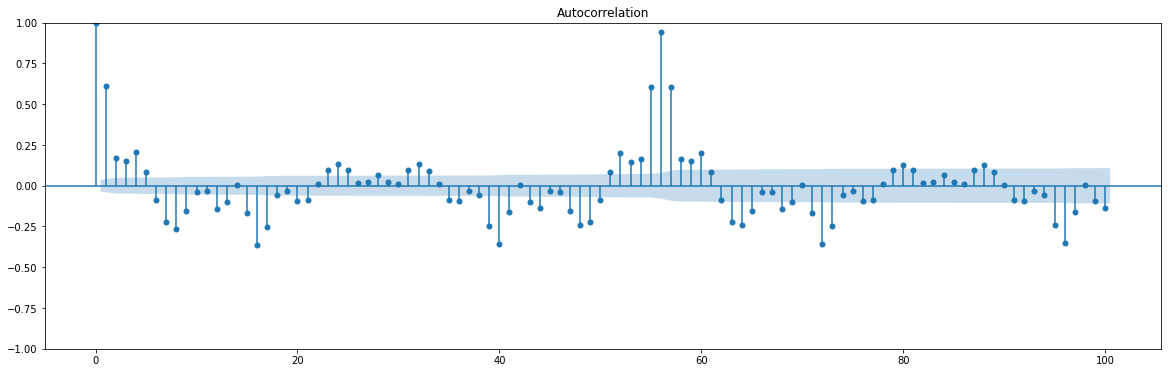

In [101]:
N, M = 20, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(flows_diff, lags=100, ax=ax)
plt.show()

The observations are the same for the flows

## Conclusion

We have the same *SARIMA* model for pressures and flows:  \
$
SARIMA(1, 0, 1)x(6, 0, 7, 8)
$

## Train model on node and link on no leakage data

### Pressures model

In [108]:
model_node_21=SARIMAX(
    pressures_no_leakage3h_mean["node_21_mean"],
    order=(1, 0, 1),
    seasonal_order=(6, 0, 7, 8),
)
model_21_fit=model_node_21.fit(maxiter=30, disp=False)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Plot forecasting on training set

Text(0.5, 1.0, 'Pressures forecasting on training set')

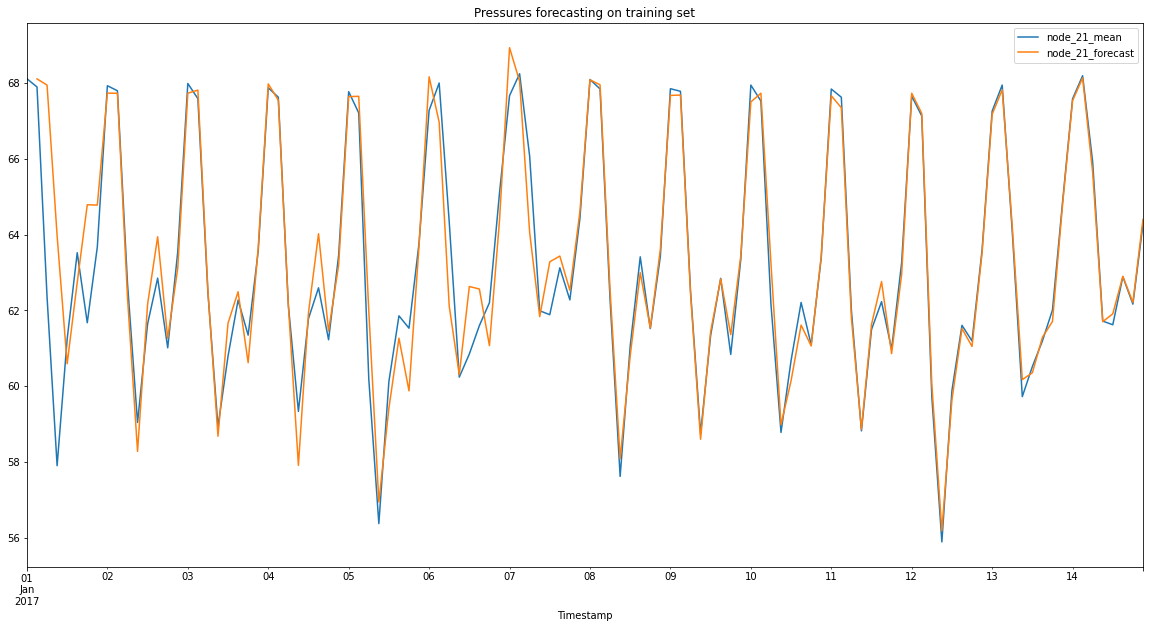

In [109]:
pressures_no_leakage3h_mean["node_21_forecast"]=model_21_fit.predict(start=1,end=2920,dynamic=False)
pressures_no_leakage3h_mean[pressures_no_leakage3h_mean.index < "2017-01-15 00:00:00"][['node_21_mean','node_21_forecast']].plot(figsize=(20,10))
plt.title("Pressures forecasting on training set")

In [143]:
model_21_fit.resid[1:]

0.3760417953400616

In [144]:
import scipy.stats as stats

stats.shapiro(model_21_fit.resid[1:])

ShapiroResult(statistic=0.8644657135009766, pvalue=9.80908925027372e-45)

In [110]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [111]:
mean_absolute_percentage_error(
    y_true=pressures_no_leakage3h_mean["node_21_mean"],
    y_pred=pressures_no_leakage3h_mean["node_21_forecast"]
)

0.4238112249229436

We see with this plot that the trained SARIMA model can forecast with a good precision our time serie.

## Flows model

In [119]:
model_link_21=SARIMAX(
    flows_no_leakage3h_mean["link_21_mean"],
    order=(1, 0, 1),
    seasonal_order=(6, 0, 7, 8), 
)
model_link_21_fit=model_link_21.fit(maxiter=5, disp=False)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Plot forecasting on training set

Text(0.5, 1.0, 'Flows forecasting on training set')

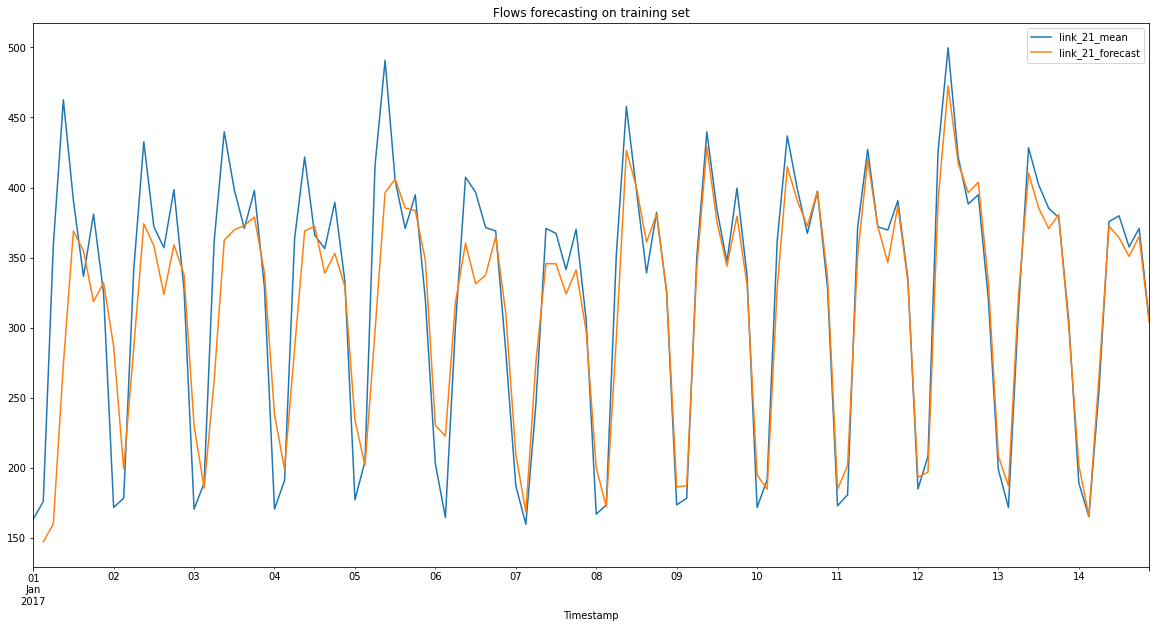

In [120]:
flows_no_leakage3h_mean["link_21_forecast"]=model_link_21_fit.predict(start=1,end=2920,dynamic=False)
flows_no_leakage3h_mean[flows_no_leakage3h_mean.index < "2017-01-15 00:00:00"][['link_21_mean','link_21_forecast']].plot(figsize=(20,10))
plt.title("Flows forecasting on training set")

In [121]:
mean_absolute_percentage_error(
    y_true=flows_no_leakage3h_mean["link_21_mean"],
    y_pred=flows_no_leakage3h_mean["link_21_forecast"]
)

4.187427568433637

## Plot forecasting on scenario with anomalies

### Scenario 5

In [23]:
pressures_leakage3h_mean = pd.read_csv('../data/aggregation/pressures_aggregated_scenario5.csv')
pressures_leakage3h_mean["Timestamp"] = pd.to_datetime(pressures_leakage3h_mean["Timestamp"])
pressures_leakage3h_mean.set_index("Timestamp", inplace=True)

flows_leakage3h_mean = pd.read_csv('../data/aggregation/flows_aggregated_scenario5.csv')
flows_leakage3h_mean["Timestamp"] = pd.to_datetime(flows_leakage3h_mean["Timestamp"])
flows_leakage3h_mean.set_index("Timestamp", inplace=True)

#### Pressures

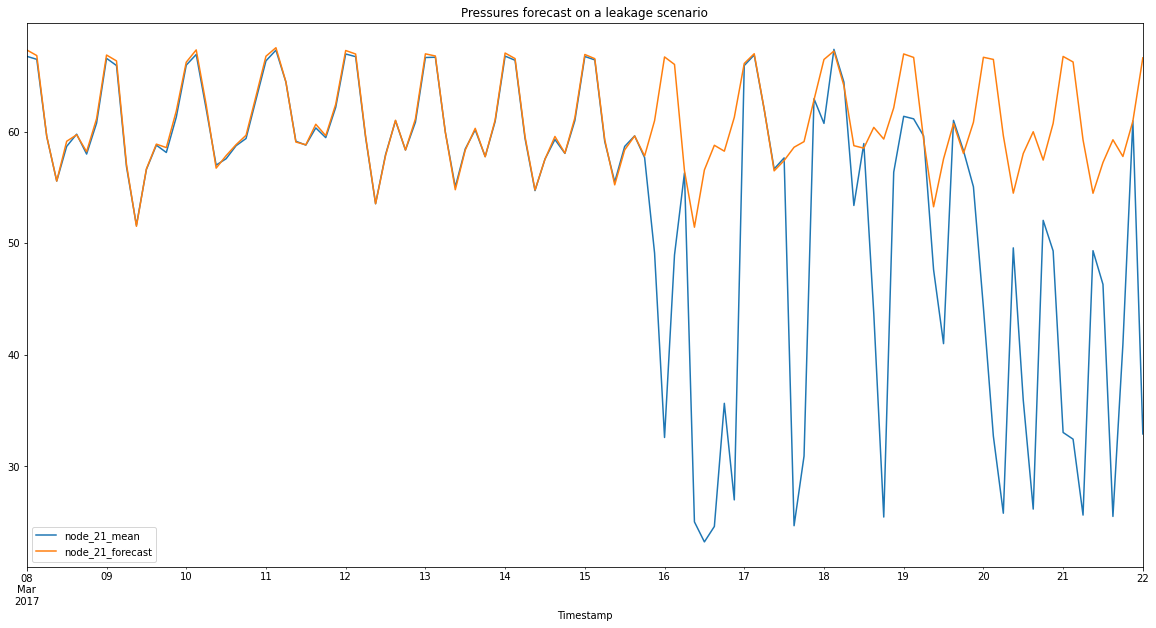

In [24]:
pressures_leakage3h_mean["node_21_forecast"]=model_21_fit.predict(start=1,end=2920,dynamic=550)
pressures_leakage3h_mean[
    (pressures_leakage3h_mean.index >= "2017-03-08 00:00:00") &
    (pressures_leakage3h_mean.index <= "2017-03-22 00:00:00")
][['node_21_mean','node_21_forecast']].plot(figsize=(20,10))
plt.title("Pressures forecast on a leakage scenario")
plt.show()

In [25]:
mean_absolute_percentage_error(
    y_true=pressures_leakage3h_mean["node_21_mean"],
    y_pred=pressures_leakage3h_mean["node_21_forecast"]
)

19.95165180007733

#### Flows

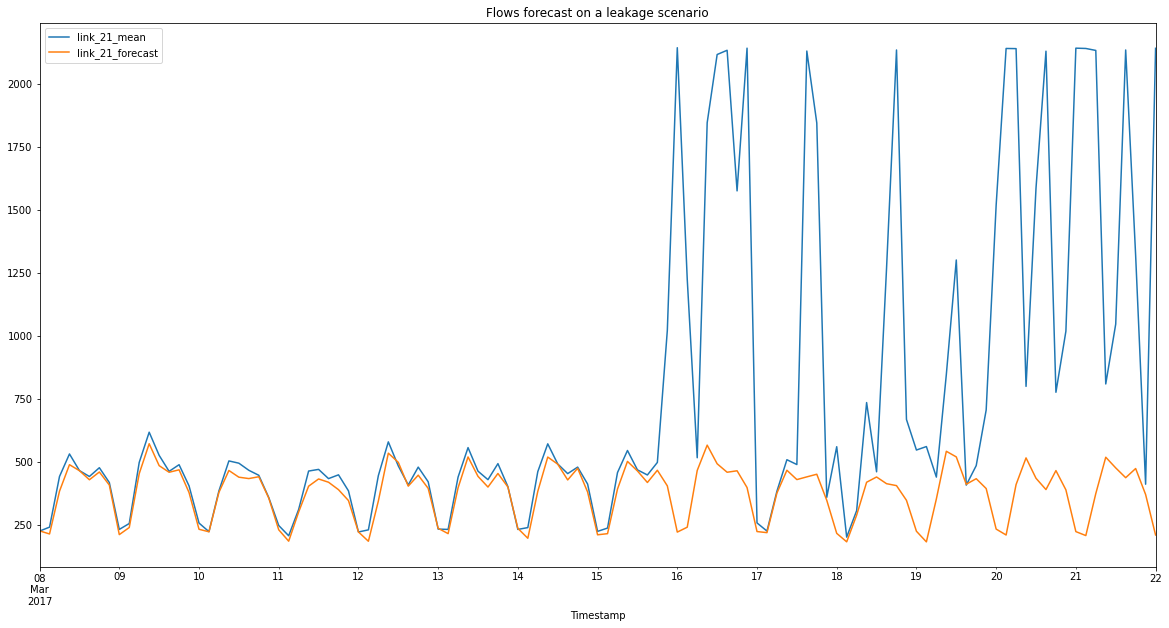

In [26]:
flows_leakage3h_mean["link_21_forecast"]=model_link_21_fit.predict(start=1,end=2920,dynamic=False)
flows_leakage3h_mean[
    (flows_leakage3h_mean.index >= "2017-03-08 00:00:00") &
    (flows_leakage3h_mean.index <= "2017-03-22 00:00:00")
][['link_21_mean','link_21_forecast']].plot(figsize=(20,10))
plt.title("Flows forecast on a leakage scenario")
plt.show()

In [27]:
mean_absolute_percentage_error(
    y_true=flows_leakage3h_mean["link_21_mean"],
    y_pred=flows_leakage3h_mean["link_21_forecast"]
)

23.434091839028596

### Scenario 78

In [31]:
pressures_leakage2_3h_mean = pd.read_csv('../data/aggregation/pressures_aggregated_scenario78.csv')
pressures_leakage2_3h_mean["Timestamp"] = pd.to_datetime(pressures_leakage2_3h_mean["Timestamp"])
pressures_leakage2_3h_mean.set_index("Timestamp", inplace=True)

flows_leakage2_3h_mean = pd.read_csv('../data/aggregation/flows_aggregated_scenario78.csv')
flows_leakage2_3h_mean["Timestamp"] = pd.to_datetime(flows_leakage2_3h_mean["Timestamp"])
flows_leakage2_3h_mean.set_index("Timestamp", inplace=True)

#### Pressures

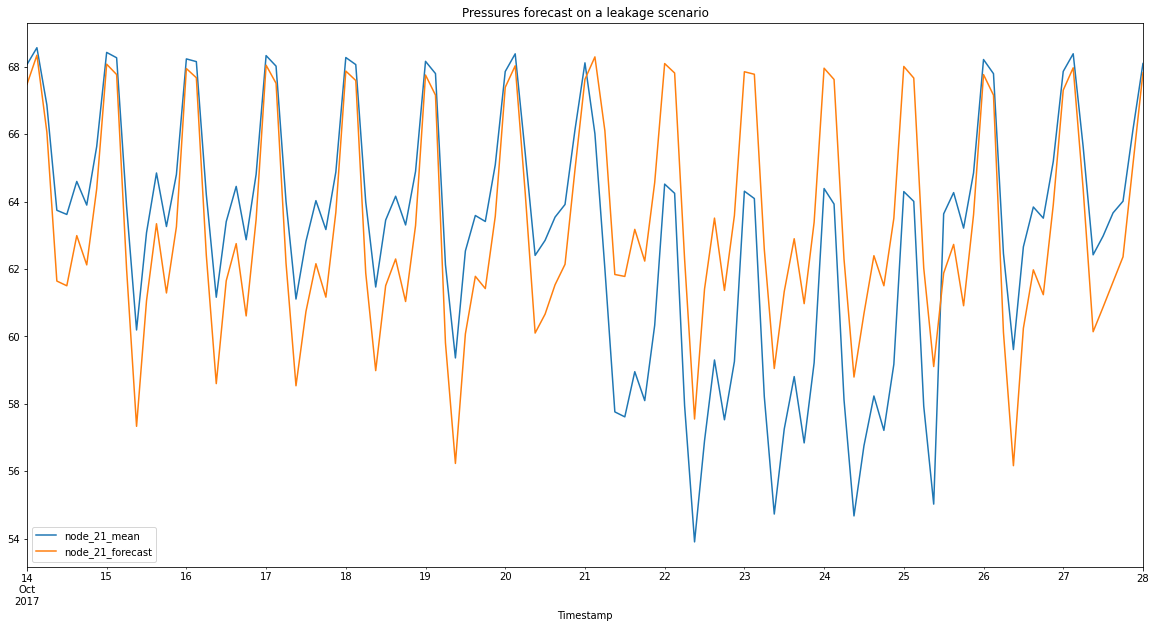

In [32]:
pressures_leakage2_3h_mean["node_21_forecast"]=model_21_fit.predict(start=1,end=2920,dynamic=False)
pressures_leakage2_3h_mean[
    (pressures_leakage2_3h_mean.index >= "2017-10-14 00:00:00") &
    (pressures_leakage2_3h_mean.index <= "2017-10-28 00:00:00")
][['node_21_mean','node_21_forecast']].plot(figsize=(20,10))
plt.title("Pressures forecast on a leakage scenario")
plt.show()

In [33]:
mean_absolute_percentage_error(
    y_true=pressures_leakage2_3h_mean["node_21_mean"],
    y_pred=pressures_leakage2_3h_mean["node_21_forecast"]
)

3.000275162312596

#### Flows

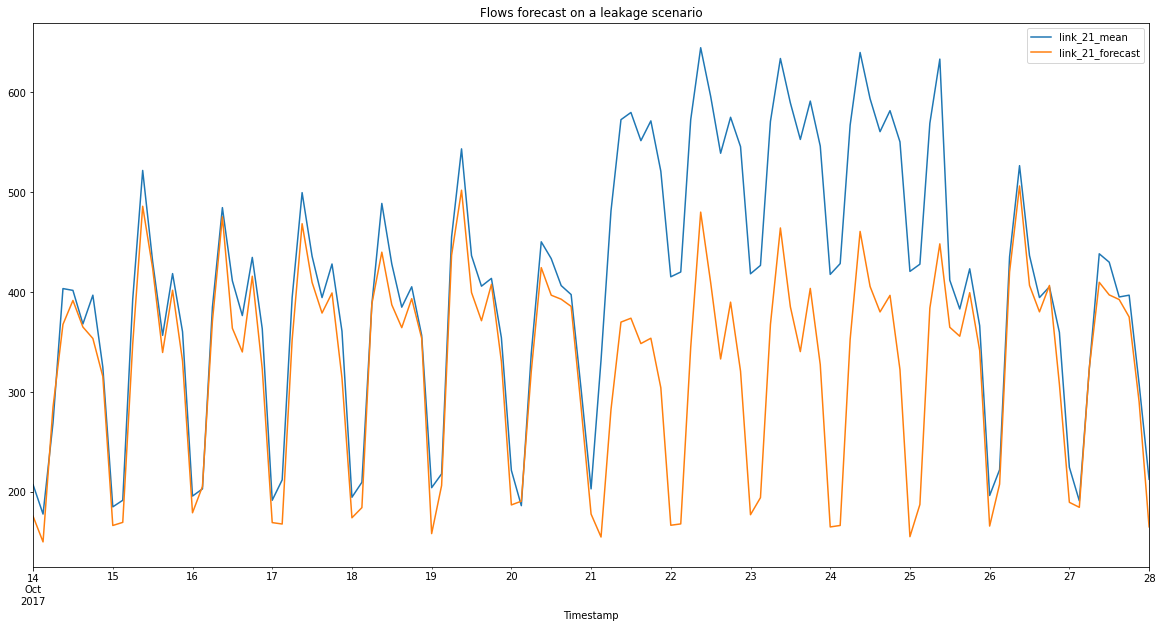

In [34]:
flows_leakage2_3h_mean["link_21_forecast"]=model_link_21_fit.predict(start=1,end=2920,dynamic=False)
flows_leakage2_3h_mean[
    (flows_leakage2_3h_mean.index >= "2017-10-14 00:00:00") &
    (flows_leakage2_3h_mean.index <= "2017-10-28 00:00:00")
][['link_21_mean','link_21_forecast']].plot(figsize=(20,10))
plt.title("Flows forecast on a leakage scenario")
plt.show()

We can easily see that the difference between the expected value (predicted) and the real value increases a lot when we have an anomaly

# Concatenate dataframes

We concatenate dataframes to obtain just one dataframe per physical phenomene (pressures and flows) to train later a supervised classification model

We shift datetime index in order to obtain a dataframe with data from 2017 to 2019

## Pressures

In [35]:
temp_pressures_leak = pressures_leakage3h_mean.reset_index().copy()
temp_pressures_leak["Timestamp"] = temp_pressures_leak["Timestamp"] + pd.offsets.DateOffset(years=1)
temp_pressures_leak.set_index("Timestamp", inplace=True)

temp_pressures_leak2 = pressures_leakage2_3h_mean.reset_index().copy()
temp_pressures_leak2["Timestamp"] = temp_pressures_leak2["Timestamp"] + pd.offsets.DateOffset(years=2)
temp_pressures_leak2.set_index("Timestamp", inplace=True)

pressures_df = pd.concat([pressures_no_leakage3h_mean, temp_pressures_leak,
                         temp_pressures_leak2], axis=0)
pressures_df["difference"] = np.abs(pressures_df["node_21_mean"] - pressures_df["node_21_forecast"])
pressures_df.fillna(0, inplace=True)

## Flows

In [36]:
temp_flows_leak = flows_leakage3h_mean.reset_index().copy()
temp_flows_leak["Timestamp"] = temp_flows_leak["Timestamp"] + pd.offsets.DateOffset(years=1)
temp_flows_leak.set_index("Timestamp", inplace=True)

temp_flows_leak2 = flows_leakage2_3h_mean.reset_index().copy()
temp_flows_leak2["Timestamp"] = temp_flows_leak2["Timestamp"] + pd.offsets.DateOffset(years=2)
temp_flows_leak2.set_index("Timestamp", inplace=True)

flows_df = pd.concat([flows_no_leakage3h_mean, temp_flows_leak, temp_flows_leak2], axis=0)
flows_df["difference"] = np.abs(flows_df["link_21_mean"] - flows_df["link_21_forecast"])
flows_df.fillna(0, inplace=True)

# Saving dataframes and SARIMA models

In [37]:
model_21_fit.save("../data/models/model_node_21_fit.pickle")
model_link_21_fit.save("../data/models/model_link_21_fit.pickle")

pressures_df.to_csv("../data/final_data/pressures_node21.csv")
flows_df.to_csv("../data/final_data/flows_link21.csv")